Text(0.5, 1.0, 'Distribution of Distances')

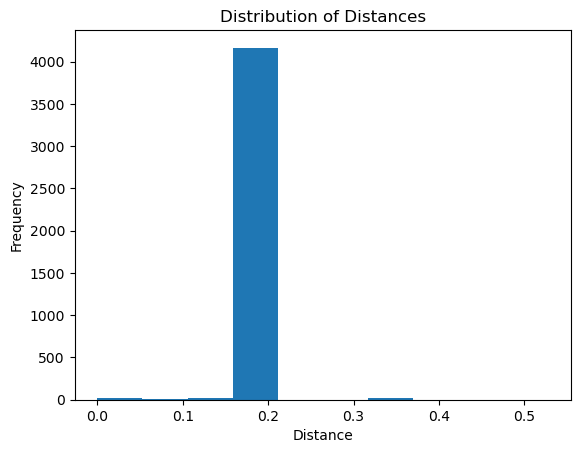

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = './out_/'

dirs = os.listdir(OUT_DIR)
dirs = [dir.split('_') for dir in dirs if '_' in dir]
dirs.sort(key=lambda x: (int(x[0]), int(x[1])))
dirs = list(filter(lambda x: int(x[0]) < 16 and int(x[1]) <= 11, dirs))

def get_path(dir):
  return OUT_DIR + '_'.join(dir) + '/dataset.csv'

def process_csv(csv_path, curvature=False):
  df = pd.read_csv(csv_path)
  df = df[df.apply(lambda x: os.path.exists(x['left_camera']) and os.path.exists(x['right_camera']), axis=1)]
  df = df[df['velocity_magnitude'] > 0.05]
  if curvature:
    # Calculate the curvature of the path
    dx = np.gradient(df['location_x'])
    dy = np.gradient(df['location_y'])
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    curvature = (d2x * dy - dx * d2y) / ((dx ** 2 + dy ** 2) ** 1.5)

    # Add the curvature column to the dataframe
    df['curvature'] = curvature

  df = df.reset_index(drop=True)
  return df
  
df = process_csv(get_path(dirs[0]))

# Calculate the distance between each pair of adjacent points
dx = np.diff(df['location_x'])
dy = np.diff(df['location_y'])
distances = np.sqrt(dx**2 + dy**2)

# Add the distances column to the dataframe
df['distances'] = np.concatenate(([0], distances))

# Create a histogram of the distances
plt.hist(distances, bins=10)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')

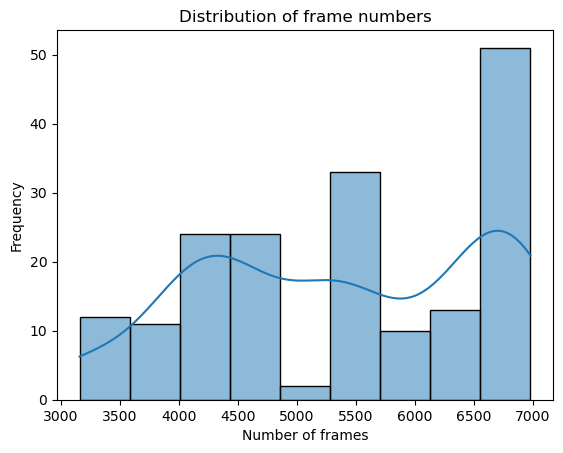

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot():
  csv_files = [get_path(dir) for dir in dirs]
  line_counts = []
  destinations = []
  route_ids = []
  weathers = []
  distances = []
  
  for csv_file in csv_files:
      csv_df = process_csv(csv_file)
      line_counts.append(len(csv_df))
      try:
        destinations.append([csv_df['location_x'].iloc[-1], csv_df['location_y'].iloc[-1]])
      except:
        destinations.append([-1, -1])
      
      total_distance = 0
      for i in range(len(csv_df) - 1):
          total_distance += np.sqrt((csv_df['location_x'].iloc[i] - csv_df['location_x'].iloc[i + 1]) ** 2 + (csv_df['location_y'].iloc[i] - csv_df['location_y'].iloc[i + 1]) ** 2)
      distances.append(total_distance)
      
      csv_name = csv_file.split('/')[-2]
      route_ids.append(csv_name.split('_')[0])
      weathers.append(csv_name.split('_')[1])

  df = pd.DataFrame({
    'csv_file': csv_files,
    'line_count': line_counts,
    'destination': destinations,
    'route': route_ids,
    'weather': weathers,
    'distances': distances,
  })
  # Create a distribution plot of the line numbers
  sns.histplot(line_counts, kde=True, bins='auto')
  plt.xlabel('Number of frames')
  plt.ylabel('Frequency')
  plt.title('Distribution of frame numbers')
  plt.show()
  return df

df = plot()

In [45]:
df.to_csv('index_.csv', index=False)

In [38]:
import cv2
import numpy as np
import os

def get_angular_threshold_func(threshold):
    def threshold_func(row):
        angular_velocity = np.sqrt(
            row['angular_velocity_x']**2 +
            row['angular_velocity_y']**2
        )
        if abs(angular_velocity) > threshold:
            return 1
        else:
            return -1
    return threshold_func
    
def steer_threshold(row, threshold=0.001):
    if abs(row['steer']) > threshold:
        return 1
    else:
        return -1
    
def find_turns(df, threshold_func, min_distance=80):
    # Initialize variables to keep track of the start and end of turns
    turn_start = None
    turn_end = None
    turns = []

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        if threshold_func(row) > 0 and turn_start is None:
            turn_start = index
        elif threshold_func(row) < 0 and turn_start is not None:
            turn_end = index - 1
            if turn_end - turn_start >= min_distance:
                turns.append((turn_start, turn_end))
            turn_start = None

    # If there is an ongoing turn at the end of the DataFrame
    if turn_start is not None:
        if df.index[-1] - turn_end >= min_distance: 
            turns.append((turn_start, df.index[-1]))

    return turns

def merge_turns(turns, min_distance=40):
    if len(turns) == 0:
        return []
    merged_turns = []
    current_turn_start = turns[0][0]
    current_turn_end = turns[0][1]

    for i in range(1, len(turns)):
        if turns[i][0] - current_turn_end <= min_distance:
            current_turn_end = turns[i][1]  # Update the end index of the current turn
        else:
            merged_turns.append((current_turn_start, current_turn_end))
            current_turn_start = turns[i][0]
            current_turn_end = turns[i][1]

    # Append the last turn
    merged_turns.append((current_turn_start, current_turn_end))
    if merged_turns[0][0] <= min_distance:
        merged_turns = merged_turns[1:]
    return merged_turns

def display_images(segment, segment_type, segment_index, frame_index):
    left_image_path = segment['left_camera'].iloc[frame_index]
    right_image_path = segment['right_camera'].iloc[frame_index]
    steer_value = segment['steer'].iloc[frame_index]
    location_x = segment['location_x'].iloc[frame_index]
    location_y = segment['location_y'].iloc[frame_index]
    velocity = segment['velocity_magnitude'].iloc[frame_index]
    angular_velocity_x = segment['angular_velocity_x'].iloc[frame_index]
    angular_velocity_y = segment['angular_velocity_y'].iloc[frame_index]
    angular_velocity_z = segment['angular_velocity_z'].iloc[frame_index]
    angular_velocity = np.sqrt(angular_velocity_x**2 + angular_velocity_y**2 + angular_velocity_z**2)

    if not os.path.exists(left_image_path) or not os.path.exists(right_image_path):
        return None

    left_image = cv2.imread(left_image_path)
    right_image = cv2.imread(right_image_path)
    
    # Calculate font scale and line spacing based on image size
    height, _, _ = left_image.shape
    font_scale = height / 480  # Adjust this value based on your desired font scale for an image with height 480
    line_spacing = int(40 * font_scale)

    # Draw the values on the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_color = {
        "Turns": (0, 255, 0),
        "Landmarks": (0, 0, 255),
        "None": (255, 255, 255),
    }[segment_type]
    cv2.putText(
        left_image,
        f'{segment_type} {segment_index} Frame {frame_index}', (10, line_spacing), font, font_scale, text_color, 2, cv2.LINE_AA
    )
    cv2.putText(
        left_image,
        f'Steering: {steer_value:.6f}', (10, line_spacing * 2), font, font_scale, text_color, 2, cv2.LINE_AA
    )
    cv2.putText(
        left_image,
        f'Location: ({location_x:.6f}, {location_y:.6f})', (10, line_spacing * 3), font, font_scale, text_color, 2, cv2.LINE_AA
    )
    cv2.putText(
        left_image,
        f'Velocity: {velocity:.6f}', (10, line_spacing * 4), font, font_scale, text_color, 2, cv2.LINE_AA
    )
    cv2.putText(
        left_image,
        f'Angular Velocity: {angular_velocity:.6f}', (10, line_spacing * 5), font, font_scale, text_color, 2, cv2.LINE_AA
    )

    combined_image = np.hstack((left_image, right_image))

    return combined_image

def display_segments(df, segments):
    if len(segments) == 0:
        print("No segments found.")
        return
    segment_index = 0
    frame_index = 0
    while True:
        segment = df.loc[segments[segment_index][0]:segments[segment_index][1], [
            'left_camera',
            'right_camera',
            'steer',
            'velocity_magnitude',
            'location_x',
            'location_y',
            'angular_velocity_x',
            'angular_velocity_y',
            'angular_velocity_z'
        ]]

        segment_type = segments[segment_index][2]
        combined_image = display_images(segment, segment_type, segment_index, frame_index)
        
        if combined_image is not None:
            cv2.imshow('Dual Images', combined_image)
        else:
            print(f"Skipping frame {frame_index} in segment {segment_index} due to missing image files.")

        key = cv2.waitKey(0) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('d'):  # Next frame
            frame_index += 1
            if frame_index >= len(segment):
                frame_index = 0
        elif key == ord('a'):  # Prev frame
            frame_index -= 1
            if frame_index < 0:
                frame_index = len(segment) - 1
        elif key == ord('w'):  # Next segment
            segment_index += 1
            if segment_index >= len(segments):
                segment_index = 0
            frame_index = 0
        elif key == ord('s'):  # Prev segment
            segment_index -= 1
            if segment_index < 0:
                segment_index = len(segments) - 1
            frame_index = 0
        elif key == ord('q'):
            break

    cv2.destroyAllWindows()

def pick_landmarks(df,turns, window_size, start_frame=100, landmark_distance=90, turn_distance=30, num_landmarks=10):
    landmarks = []
    total_rows = len(df)
    current_frame = start_frame
    counts = 0

    while current_frame < total_rows - window_size:
        start = current_frame
        end = start + window_size - 1

        too_close_to_turn = False
        for turn_start, turn_end in turns:
            if (turn_start - turn_distance <= start <= turn_end + turn_distance) or (turn_start - turn_distance <= end <= turn_end + turn_distance):
                too_close_to_turn = True
                break
        too_close_to_landmark = False
        for landmark_start, landmark_end in landmarks:
            if (landmark_start - landmark_distance <= start <= landmark_end + landmark_distance) or (landmark_start - landmark_distance <= end <= landmark_end + landmark_distance):
                too_close_to_landmark = True
                break

        if not too_close_to_turn and not too_close_to_landmark:
            landmarks.append((start, end))
            current_frame = end + landmark_distance + 1
            counts += 1
            if counts >= num_landmarks:
                break
        else:
            current_frame += 1

    return landmarks

In [39]:
def generate_segments(df):
    turns = find_turns(df, threshold_func=get_angular_threshold_func(0.10), min_distance=40)
    turns = merge_turns(turns, min_distance=80)
    landmarks = pick_landmarks(
      df,
      turns,
      start_frame=110,
      window_size=40,
      landmark_distance=160,
      turn_distance=60,
      num_landmarks=30
    )
    turns = [(start, end, "Turns") for start, end in turns]
    landmarks = [(start, end, "Landmarks") for start, end in landmarks]
    return turns, landmarks
  
path = get_path(dirs[0])
df = process_csv(path)
turns, landmarks = generate_segments(df)
display_segments(df, landmarks)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to tar

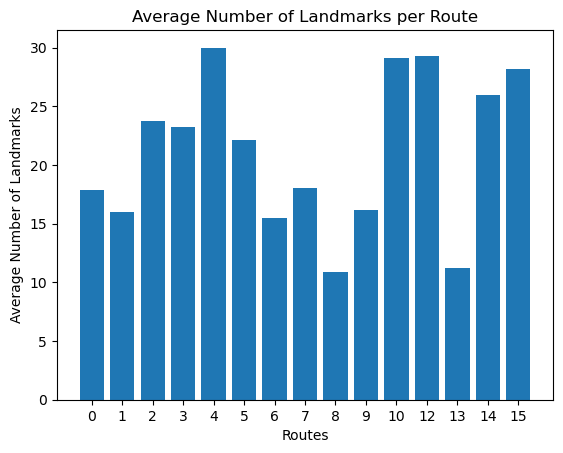

In [40]:
import matplotlib.pyplot as plt
# Accumulate landmark counts per route
lap_turns = {}
lap_landmarks = {}
landmark_counts = {}

for dir in dirs:
    df = process_csv(get_path(dir))
    turns, landmarks = generate_segments(df)
    route = dir[0]
    lap_turns.setdefault(route, []).append(turns)
    lap_landmarks.setdefault(route, []).append(landmarks)
    landmark_counts.setdefault(route, []).append(len(landmarks))

# Calculate average landmark counts per route
average_landmark_counts = {route: sum(counts) / len(counts) for route, counts in landmark_counts.items()}

# Plot the average landmark counts
routes = list(average_landmark_counts.keys())
avg_counts = list(average_landmark_counts.values())

plt.bar(routes, avg_counts)
plt.xlabel('Routes')
plt.ylabel('Average Number of Landmarks')
plt.title('Average Number of Landmarks per Route')
plt.show()


In [41]:
def create_all_segments(turns, landmarks):
    all_segments = turns + landmarks
    all_segments.sort(key=lambda x: x[0])
    
    filled_segments = []
    for i in range(len(all_segments) - 1):
        filled_segments.append(all_segments[i])
        gap_start = all_segments[i][1] + 1
        gap_end = all_segments[i + 1][0] - 1
        if gap_start <= gap_end:
            filled_segments.append((gap_start, gap_end, "None"))
    filled_segments.append(all_segments[-1])
    return filled_segments

# segments = create_all_segments(turns, landmarks)
# display_segments(df, segments)

In [42]:
laps = {}
for dir in dirs:
    route = dir[0]
    laps.setdefault(route, []).append(process_csv(get_path(dir)))

In [43]:
def find_min_landmark_lap(landmark_counts, route):
    min_index = np.argmin(landmark_counts[str(route)])
    return min_index

def extract_landmark_locations(df, landmarks):
    landmark_locations = []
    for start_frame, end_frame, _ in landmarks:
        start_location = df.iloc[start_frame][["location_x", "location_y"]].to_numpy()
        end_location = df.iloc[end_frame][["location_x", "location_y"]].to_numpy()
        landmark_locations.append((start_location, end_location))
    return landmark_locations

def find_corresponding_frames(df, landmark_locations):
    corresponding_frames = []
    for start_location, end_location in landmark_locations:
        start_frame_idx = ((df["location_x"] - start_location[0])**2 + (df["location_y"] - start_location[1])**2).idxmin()
        end_frame_idx = ((df["location_x"] - end_location[0])**2 + (df["location_y"] - end_location[1])**2).idxmin()
        
        corresponding_frames.append((start_frame_idx, end_frame_idx))
    return corresponding_frames

def compute_corresponding_frames_for_all_laps(route_laps, min_landmark_lap, min_landmark_frames):
    lap_segments = []

    for lap_df in route_laps:
        if lap_df is not min_landmark_lap:
            corresponding_frames = find_corresponding_frames(lap_df, min_landmark_locations)
            lap_segments.append(corresponding_frames)
        else:
            lap_segments.append(min_landmark_frames)

    return lap_segments

selected_segments = {}

for route, route_laps in laps.items():
    min_landmark_lap_index = find_min_landmark_lap(landmark_counts, route)
    min_landmark_frames = lap_landmarks[route][min_landmark_lap_index]
    min_landmark_locations = extract_landmark_locations(route_laps[min_landmark_lap_index], min_landmark_frames)

    corresponding_frames = compute_corresponding_frames_for_all_laps(route_laps, min_landmark_frames, min_landmark_locations)
    selected_segments[route] = corresponding_frames

In [89]:
def resize_and_display_text(image, text_info, size=(400, 200)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    text_color = (255, 255, 255)
    line_spacing = 20

    for idx, (key, value) in enumerate(text_info.items()):
        cv2.putText(resized_image, f'{key}: {value}', (5, line_spacing * (idx + 1)), font, font_scale, text_color, 1, cv2.LINE_AA)

    return resized_image

def combine_images(images, grid_size=(3, 4), margin=10):
    h, w = images[0].shape[:2]
    output_image = np.zeros((h * grid_size[0] + margin * (grid_size[0] - 1),
                             w * grid_size[1] + margin * (grid_size[1] - 1), 3), dtype=np.uint8)

    for idx, img in enumerate(images):
        x_offset = (idx % grid_size[1]) * (w + margin)
        y_offset = (idx // grid_size[1]) * (h + margin)
        output_image[y_offset:y_offset + h, x_offset:x_offset + w] = img

    return output_image

def display_grid(route, segments, current_segment, current_frame):
    images = []
    for lap_idx, lap_segments in enumerate(segments):
        start_frame, end_frame = lap_segments[current_segment]
        frame_idx = start_frame + current_frame

        if frame_idx > end_frame:
            black_image = np.zeros((200, 800, 3), dtype=np.uint8)
            black_image = resize_and_display_text(black_image, {
                'Type': 'Finished',
                'Index': current_segment,
            })
            images.append(black_image)
            continue

        segment = laps[route][lap_idx].iloc[frame_idx]
        left_image_path = segment['left_camera']
        right_image_path = segment['right_camera']

        if not os.path.exists(left_image_path) or not os.path.exists(right_image_path):
            continue

        left_image = cv2.imread(left_image_path)
        right_image = cv2.imread(right_image_path)
        combined_image = np.hstack((left_image, right_image))

        text_info = {
            'Type': 'Landmarks',
            'Index': current_segment,
            'Lap': lap_idx + 1,
            'Frame': current_frame
        }

        resized_image = resize_and_display_text(combined_image, text_info)
        images.append(resized_image)

    combined_grid = combine_images(images)
    cv2.imshow(f"Route: {route}", combined_grid)


def display_lap_segments(current_route=None):
    current_segment = 0
    current_frame = 0

    while True:
        try:
            display_grid(current_route, selected_segments[current_route], current_segment, current_frame)
        except Exception as e:
            print(e)
            break
        key = cv2.waitKey(0) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('d'):  # Next frame
            current_frame += 1
        elif key == ord('a'):  # Prev frame
            current_frame -= 1
            if current_frame < 0:
                current_frame = 0
        elif key == ord('w'):  # Next segment
            current_segment += 1
            current_frame = 0
            if current_segment >= len(selected_segments[current_route][0]):
                current_segment = 0
        elif key == ord('s'):  # Prev segment
            current_segment -= 1
            current_frame = 0
            if current_segment < 0:
                current_segment = len(selected_segments[current_route][0]) - 1

    cv2.destroyAllWindows()

display_lap_segments(current_route='5')

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to target thread (0x558ae33550a0)

QObject::moveToThread: Current thread (0x558ae33550a0) is not the object's thread (0x558ae35494a0).
Cannot move to tar

In [49]:
import os

def get_image_durations_from_splits(route, positive=True):
    durations = []
    for lap in range(12):
        lap_path = f'./splits/{route}/{lap}'
        if not os.path.exists(lap_path):
            continue
        for segment in os.listdir(lap_path):
            if segment.endswith('positive') == positive:
                segment_path = os.path.join(lap_path, segment)
                image_count = len([f for f in os.listdir(segment_path) if f.endswith('.png')])
                durations.append(image_count)
                if image_count < 100:
                    print(route, lap, segment, image_count)
    return durations

frame_durations = []
for route in [f'{idx}' for idx in range(16)]:
    frame_durations += get_image_durations_from_splits(route, False)


4 5 000_negative 98
4 7 000_negative 98
5 6 190_negative 90


In [50]:
min(frame_durations)

90

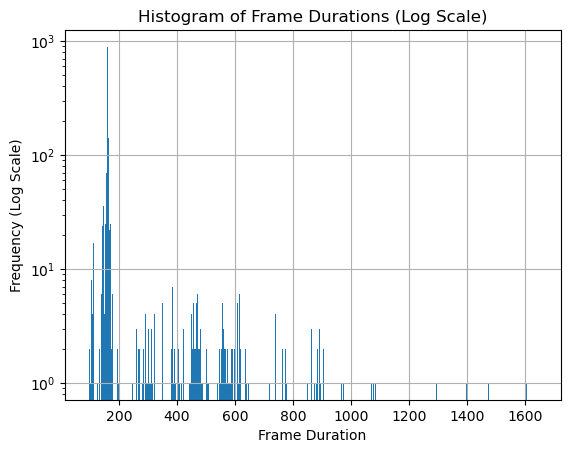

In [51]:
def plot_frame_durations(frame_durations):
    plt.hist(frame_durations, bins=range(min(frame_durations), max(frame_durations) + 2), align='left', log=True)
    plt.xlabel('Frame Duration')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Histogram of Frame Durations (Log Scale)')
    plt.grid(True)
    plt.show()

plot_frame_durations(frame_durations)


In [58]:
def label_frames(route, lap, lap_df, lap_turns, selected_segments):
    labels = ["none"] * len(lap_df)

    for start, end, _ in lap_turns:
        for idx in range(start, end + 1):
            labels[idx] = "turn"

    for start, end in selected_segments:
        for idx in range(start, end + 1):
            if idx > len(labels) - 1:
                print(route, lap, start, end, idx, len(labels))
            labels[idx] = "landmark"

    lap_df["label"] = labels
    return lap_df

# Update the laps dataframes with the "label" column
for route in laps:
    for i, lap_df in enumerate(laps[route]):
        lap_df = label_frames(route, i, lap_df, lap_turns[route][i], selected_segments[route][i])
        lap_df.to_csv(f'./out_/csv/{route}_{i}.csv', index=False)


In [47]:
def segment_lap_df(lap_df):
    segments = {}
    last_positive_end = -1
    i = 0

    while i < len(lap_df):
        # Find the start of a positive segment
        if lap_df['label'].iloc[i] == 'landmark':
            positive_start = i

            # Find the end of the positive segment
            while i < len(lap_df) and lap_df['label'].iloc[i] == 'landmark':
                i += 1

            positive_end = i - 1

            # Define the positive segment
            segments[f'{len(segments)//2:02d}1_positive'] = (positive_start, positive_end)

            # Define the negative segment paired with the positive segment
            segments[f'{len(segments)//2:02d}0_negative'] = (last_positive_end + 1, positive_start - 1)

            last_positive_end = positive_end
        else:
            i += 1

    return segments

segmented_laps = {}

for route, route_laps in laps.items():
    segmented_laps[route] = [segment_lap_df(lap_df) for lap_df in route_laps]


In [48]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor

def split_image_segments(args):
    route, lap, segments, df = args
    os.makedirs(f'./splits/{route}/{lap}', exist_ok=True)
    
    for segment, (start, end) in segments.items():
        segment_dir = f'./splits/{route}/{lap}/{segment}'
        os.makedirs(segment_dir, exist_ok=True)
        
        for idx, (left_image_path, right_image_path) in enumerate(df.loc[start:end, ["left_camera", "right_camera"]].values):
            left_image = cv2.imread(left_image_path)
            right_image = cv2.imread(right_image_path)
            combined_image = cv2.hconcat([left_image, right_image])
            output_filename = f'{idx:05d}.png'
            output_path = os.path.join(segment_dir, output_filename)
            cv2.imwrite(output_path, combined_image)

def process_laps_parallel(segmented_laps, laps):
    tasks = []
    for route, lap_segments in segmented_laps.items():
        for lap_idx, segments in enumerate(lap_segments):
            tasks.append((route, lap_idx, segments, laps[route][lap_idx]))

    with ProcessPoolExecutor() as executor:
        executor.map(split_image_segments, tasks)

process_laps_parallel(segmented_laps, laps)


In [63]:
split_image_segments(args=('5', 8, segmented_laps['5'][8], laps['5'][8]))

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import shutil
import os

def compress_route_folder(route):
    print(f'Compressing {route}')
    route_folder = f'./splits/{route}'
    output_zip = f'./splits/{route}.zip'

    if os.path.exists(output_zip):
        os.remove(output_zip)

    shutil.make_archive(route_folder, 'zip', route_folder)
    print(f'Compressed {route_folder} into {output_zip}')

routes = [int(route) for route in os.listdir('./splits') if os.path.isdir(f'./splits/{route}')]
for route in routes:
    compress_route_folder(route)


In [ ]:
# Compress the out folders
import os
import zipfile
from concurrent.futures import ProcessPoolExecutor

def compress_folders(prefix, out_folder):
    print("Compressing ", prefix, "...")
    zip_filename = f"{prefix}.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in os.listdir(out_folder):
            if folder.startswith(f"{prefix}_"):
                folder_path = os.path.join(out_folder, folder)
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        zipf.write(file_path, os.path.relpath(file_path, out_folder))

def compress_all_folders(prefixes, out_folder):
    with ProcessPoolExecutor() as executor:
        for prefix in prefixes:
            executor.submit(compress_folders, prefix, out_folder)

# Example usage:
out_folder = "./out_"
prefixes = [str(i) for i in range(16)]
compress_all_folders(prefixes, out_folder)

In [153]:
import os
import shutil
import pandas as pd

def rearrange_images(route, lap, csv_path):
    input_dir = f'./splits_50/{route}/{lap}'
    output_segment_dir = f'./splits_rearranged/{route}/{lap}'
    os.makedirs(output_segment_dir, exist_ok=True)
    
    # Read the new CSV file
    df = pd.read_csv(csv_path)
    
    # Get the image names from existing negative and positive folders
    all_images = []
    for segment_dir in sorted(os.listdir(input_dir)):
        segment_path = os.path.join(input_dir, segment_dir)
        if os.path.isdir(segment_path):
            segment_images = sorted(os.listdir(segment_path))
            all_images.extend([os.path.join(segment_path, image_name) for image_name in segment_images])
            
    # Rearrange the images based on the new CSV
    prev_segment = 'landmark'
    segment_idx = 0
    
    output_dirs = []
    for idx, image_path in enumerate(all_images):
        label = df.iloc[idx]['label']
        
        if prev_segment == 'landmark' and label != 'landmark':
            output_dirs.append(os.path.join(output_segment_dir, f"{segment_idx:02d}0_negative"))
            output_dirs.append(os.path.join(output_segment_dir, f"{segment_idx:02d}1_positive"))
            segment_idx += 1
        prev_segment = label

        
    for output_dir in output_dirs:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=False)
    image_idx = 0
    segment_idx = -1
    prev_segment = 'landmark'
    for idx, image_path in enumerate(all_images):
        if not os.path.exists(image_path):
            print(image_path)
        switch = (prev_segment != 'landmark' and df.iloc[idx]['label'] == 'landmark')
        switch |= (prev_segment == 'landmark' and df.iloc[idx]['label'] != 'landmark')
        if switch:
            segment_idx += 1
            image_idx = 0
        if segment_idx >= len(output_dirs):
            break
        output_image_path = os.path.join(output_dirs[segment_idx], f'{image_idx:05d}.png')
        if not os.path.exists(output_image_path):
            shutil.copy(image_path, output_image_path)
        image_idx += 1
        prev_segment = df.iloc[idx]['label']

# Example usage:
route = "5"
lap = "0"
csv_path = f"./out_/csv/{route}_{lap}.csv"
rearrange_images(route, lap, csv_path)

['./splits_rearranged/5/0/000_negative', './splits_rearranged/5/0/001_positive', './splits_rearranged/5/0/010_negative', './splits_rearranged/5/0/011_positive', './splits_rearranged/5/0/020_negative', './splits_rearranged/5/0/021_positive', './splits_rearranged/5/0/030_negative', './splits_rearranged/5/0/031_positive', './splits_rearranged/5/0/040_negative', './splits_rearranged/5/0/041_positive', './splits_rearranged/5/0/050_negative', './splits_rearranged/5/0/051_positive', './splits_rearranged/5/0/060_negative', './splits_rearranged/5/0/061_positive', './splits_rearranged/5/0/070_negative', './splits_rearranged/5/0/071_positive', './splits_rearranged/5/0/080_negative', './splits_rearranged/5/0/081_positive', './splits_rearranged/5/0/090_negative', './splits_rearranged/5/0/091_positive', './splits_rearranged/5/0/100_negative', './splits_rearranged/5/0/101_positive', './splits_rearranged/5/0/110_negative', './splits_rearranged/5/0/111_positive', './splits_rearranged/5/0/120_negative',

In [154]:
import os

def compare_splits(original_splits_path, rearranged_splits_path):
    original_dirs = sorted(os.listdir(original_splits_path))
    rearranged_dirs = sorted(os.listdir(rearranged_splits_path))

    if original_dirs != rearranged_dirs:
        print("Directory lists are not the same.")
        return

    for segment_dir in original_dirs:
        original_segment_path = os.path.join(original_splits_path, segment_dir)
        rearranged_segment_path = os.path.join(rearranged_splits_path, segment_dir)

        original_images = sorted(os.listdir(original_segment_path))
        rearranged_images = sorted(os.listdir(rearranged_segment_path))

        if original_images != rearranged_images:
            print(f"Image lists in {segment_dir} are not the same.")

# Example usage:
route = "5"
lap = "0"
original_splits_path = f"./splits/{route}/{lap}"
rearranged_splits_path = f"./splits_rearranged/{route}/{lap}"
compare_splits(original_splits_path, rearranged_splits_path)


Image lists in 190_negative are not the same.
Image lists in 191_positive are not the same.
